##Визуальный поиск

###Обучение словаря визуальных слов

In [38]:
%matplotlib inline
import cv2
import numpy as np
from skimage import io
from skimage import feature
from skimage import color
from matplotlib import pyplot as plt
from collections import defaultdict
#import matplotlib.cbook 
import os
import sys
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import cPickle as pickle
from sklearn import svm
from sklearn.preprocessing import normalize

In [173]:
def image_generator():
    train_dir = 'base'
    for image_name in os.listdir(train_dir):
        image = cv2.imread(train_dir+"/"+ image_name)        
        yield cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
def get_descriptors(image_generator):
    descriptors = []
    sift = cv2.SIFT()
    for image in image_generator():
        keys, desc = sift.detectAndCompute(image, None)
        for d, k in zip(desc, keys):
            descriptors.append(d)
    return descriptors

def get_visual_dictionary(clusters_number, image_generator):
    print 'Calculating descriptors...'
    descriptors = get_descriptors(image_generator)
    print 'Training...'
    cls = KMeans(n_clusters=clusters_number)
    cls.fit(descriptors)
    return cls.cluster_centers_

visual_dict = get_visual_dictionary(10000, image_generator)
print 'Saving visual dictionary...'
pickle.dump(visual_dict, open('visual_dictionary.pkl', 'wb'))

Calculating descriptors...
Training...
Saving visual dictionary...


In [174]:
visual_dict = pickle.load(open('visual_dictionary.pkl', 'rb'))

###Вычисление дескрипторов Bag-Of-Words

In [175]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(visual_dict)
def get_BOW_descriptor(image, neigh):
    sift = cv2.SIFT()
    keys, descriptors = sift.detectAndCompute(image, None)
    bow_hist = np.zeros(len(visual_dict))
    for desc in descriptors:
        vis_word = neigh.kneighbors(desc, return_distance=False)
        bow_hist[vis_word[0][0]] += 1
    bow_hist = normalize(np.sqrt(bow_hist), norm='l2')
    return bow_hist
    
bow_descriptors = []
images = []
train_dir = 'base'
for image_name in os.listdir(train_dir):
    image = cv2.imread(train_dir+"/"+ image_name)
    images.append(train_dir+"/"+ image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bow_descriptors.append(get_BOW_descriptor(image, neigh)[0])

###Поиск

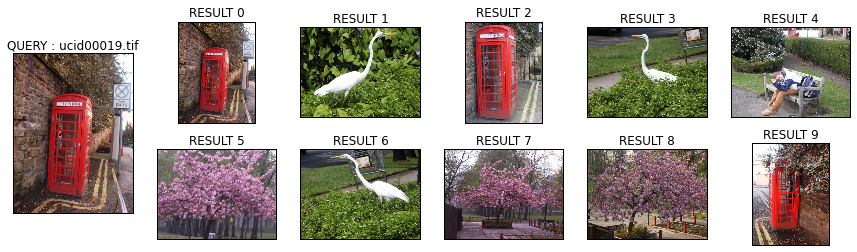

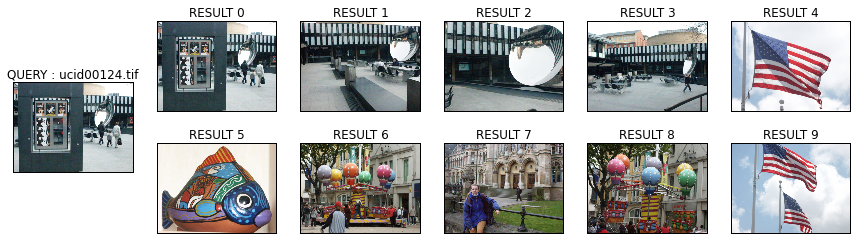

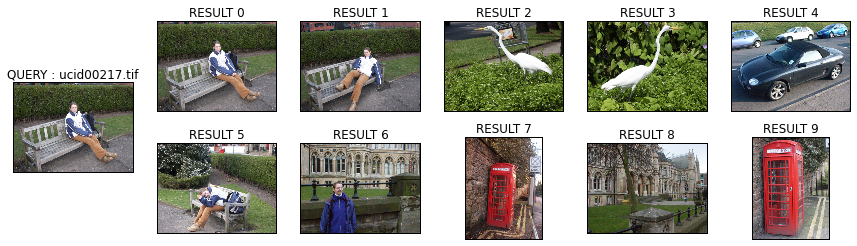

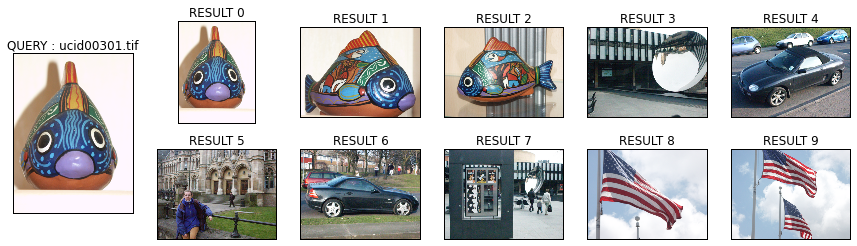

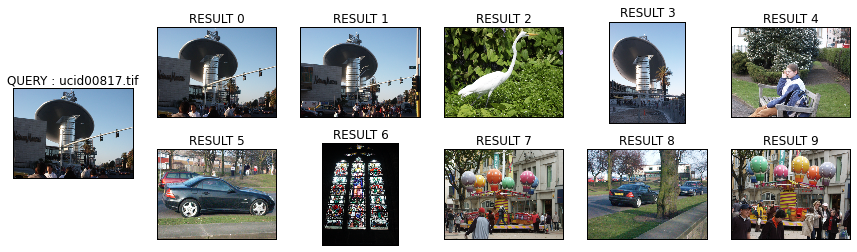

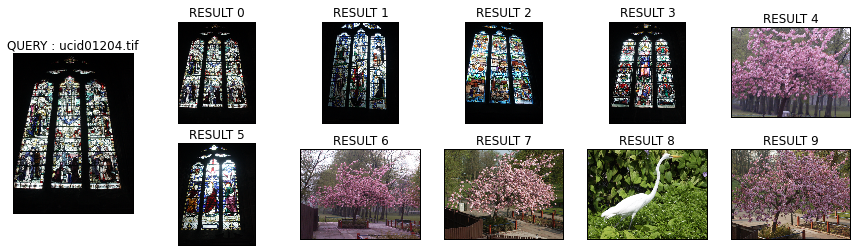

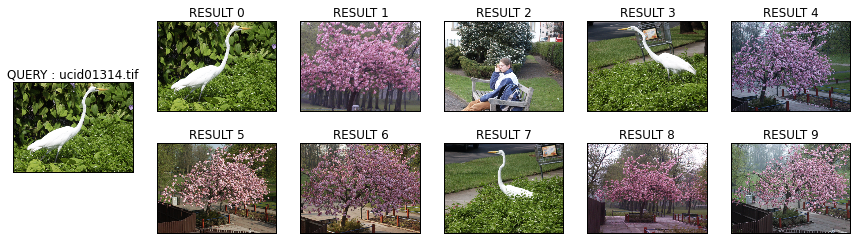

In [182]:
bow_neigh = NearestNeighbors(n_neighbors=10)
bow_neigh.fit(bow_descriptors)

def search(query, bow_neigh):
    results =[]
    bow_desc = get_BOW_descriptor(query, neigh)
    kneigh = bow_neigh.kneighbors(bow_desc, return_distance=False)
    return [images[num] for num in kneigh[0]]

def visualize(query, result, query_name):
    fig = plt.figure(figsize=(15, 4)) 
    plt.subplot2grid((2,6), (0, 0), rowspan=2)
    plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.title('QUERY' +' : '+ query_name)
    for k, image_name in enumerate(result):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot2grid((2,6), (k//5, k%5+1), colspan=1)
        plt.imshow(image)
        plt.xticks([]), plt.yticks([])
        plt.title('RESULT %d' % k)
    plt.show()

query_dir = 'queries'
results = {}
for image_name in os.listdir(query_dir):
    image = cv2.imread(query_dir+"/"+ image_name)        
    query = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = search(query, bow_neigh)
    results[query_dir+"/"+ image_name]=result
    visualize(image, result, image_name)
        

###Поиск с RANSAC

In [183]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
sift = cv2.SIFT()
pansac_results = {}
for query_name in results.keys():
    masks = []
    query = cv2.imread(query_name)        
    query = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)
    keys_1, desc_1 = sift.detectAndCompute(query, None)
    for image_name in results[query_name]:
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keys_2, desc_2 = sift.detectAndCompute(image, None)
        matches = matcher.match(desc_1, desc_2)
        src_pts = np.float32([keys_1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([keys_2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
        masks.append([x[0] for x in mask])
    items = zip(masks, results[query_name])
    items = sorted(items, key = lambda x: np.sum(x[0]), reverse=True)
    pansac_results[query_name] = [it[1] for it in items]

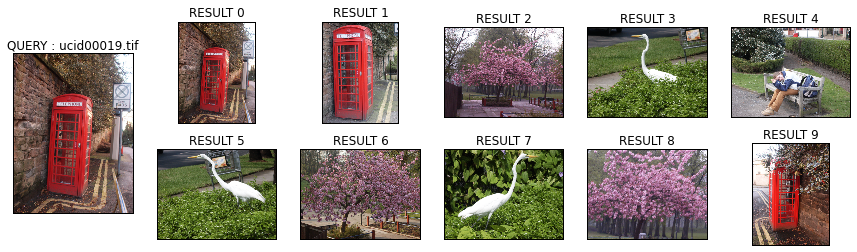

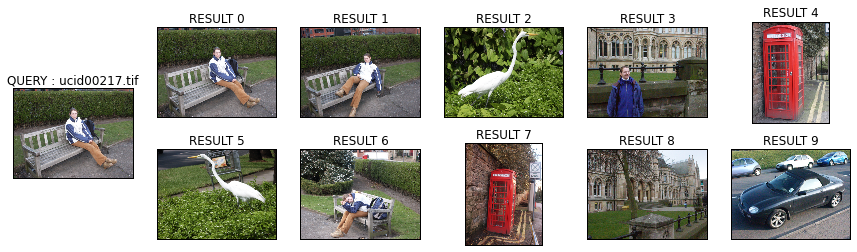

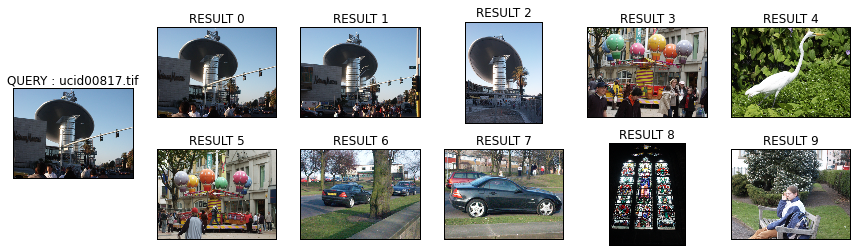

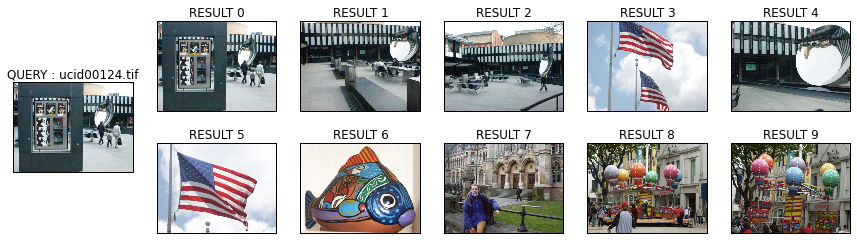

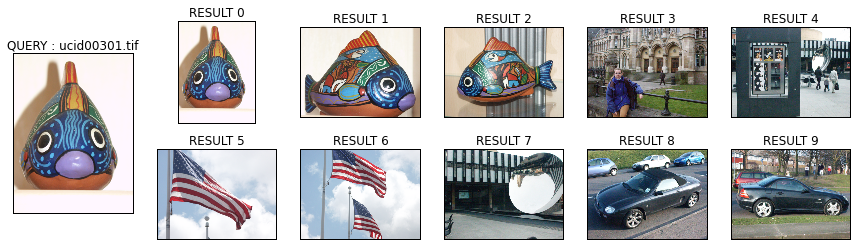

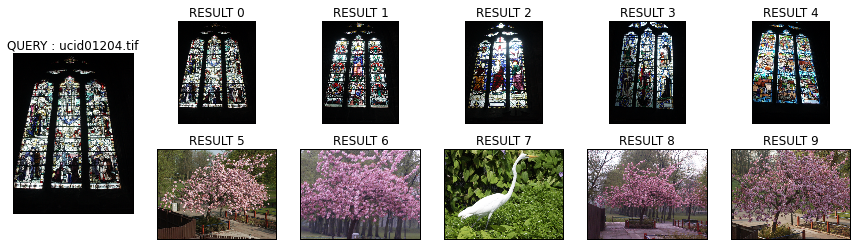

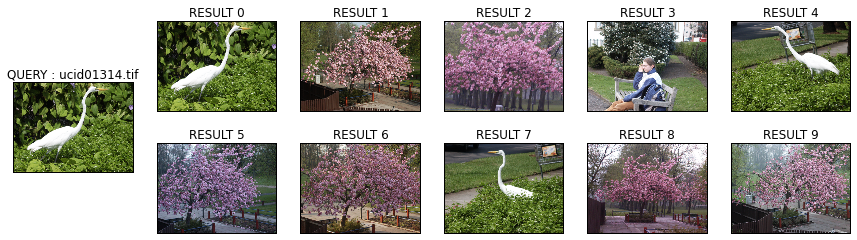

In [184]:
for query_name in pansac_results.keys():
    query = cv2.imread(query_name)        
    visualize(query, pansac_results[query_name], query_name.split('/')[1])

Можно заметить, что результаты поиска улучшились для запросов udid00019, udid00817, udid01204.